# Making and choosing the Classification Model

## Loading the processed data

In [ ]:
#Importing the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
sns.set_style('whitegrid')
pd.set_option('display.max_columns', None) 
from sklearn.model_selection import train_test_split
#Loading the processed data
train = pd.read_csv("data/processed/processed_train.csv")

## Splitting the data into training and validation sets

In [74]:
import re
train = train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [78]:
x = train.drop(['title','hitFlop','Unnamed0'],axis=1)
y = train['hitFlop']

X_train,X_valid,y_train,y_valid = train_test_split(x,y,test_size=0.2,stratify=y,random_state=1)

## Defining a model accuracy metric

* Based on the EDA done in the previous notebook, we can see that the data is quite skewed i.e. the number of data points with category 1 is much much more than some other categories like 8 or 9.

* So for imbalanced datasets, we can use ROC-AUC score to calculate how well our classifier is doing on the validation dataset

* ROC-AUC score is independent of the threshold set for classification because it only considers the rank of each prediction and not its absolute value. The same is not true for other metrics like F1 score which needs a threshold value in case of probabilities output.

### General AUC predictions:
 * .90-1 = Excellent
 * .80-.90 = Good
 * .70-.80 = Fair
 * .60-.70 = Poor
 * .50-.60 = Fail

## Making the prediction model

First we'll train different models on the data without tuning any hyperparameters.

Based on the corresponding results,we will choose the model to use for classification

In [111]:
#Importing all models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score,roc_auc_score

diff_models = [LogisticRegression(max_iter=1000,multi_class='multinomial',verbose=0),
               DecisionTreeClassifier(),RandomForestClassifier(),ExtraTreesClassifier(),
              XGBClassifier(),LGBMClassifier(),CatBoostClassifier(logging_level='Silent')]
a = []
b = []
for model in diff_models:
    model.fit(X_train,y_train)
    print('{} Test error : {}'.format(str(model).split('(')[0].split('.')[0],roc_auc_score(y_valid,model.predict_proba(X_valid),multi_class='ovr')))
    a.append(roc_auc_score(y_valid,model.predict_proba(X_valid),multi_class='ovr'))
    b.append(roc_auc_score(y_train,model.predict_proba(X_train),multi_class='ovr'))

F:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression Test error : 0.7169635599767018
BernoulliNB Test error : 0.7438343707168874
DecisionTreeClassifier Test error : 0.5282577194348745
RandomForestClassifier Test error : 0.7034023761547208
ExtraTreesClassifier Test error : 0.7065210241591516
XGBClassifier Test error : 0.7543224469320422
LGBMClassifier Test error : 0.7370953361559697
<catboost Test error : 0.7630614261695419


[Text(0, 0.5, 'ROC_AUC_Score'), Text(0.5, 1.0, 'Training error')]

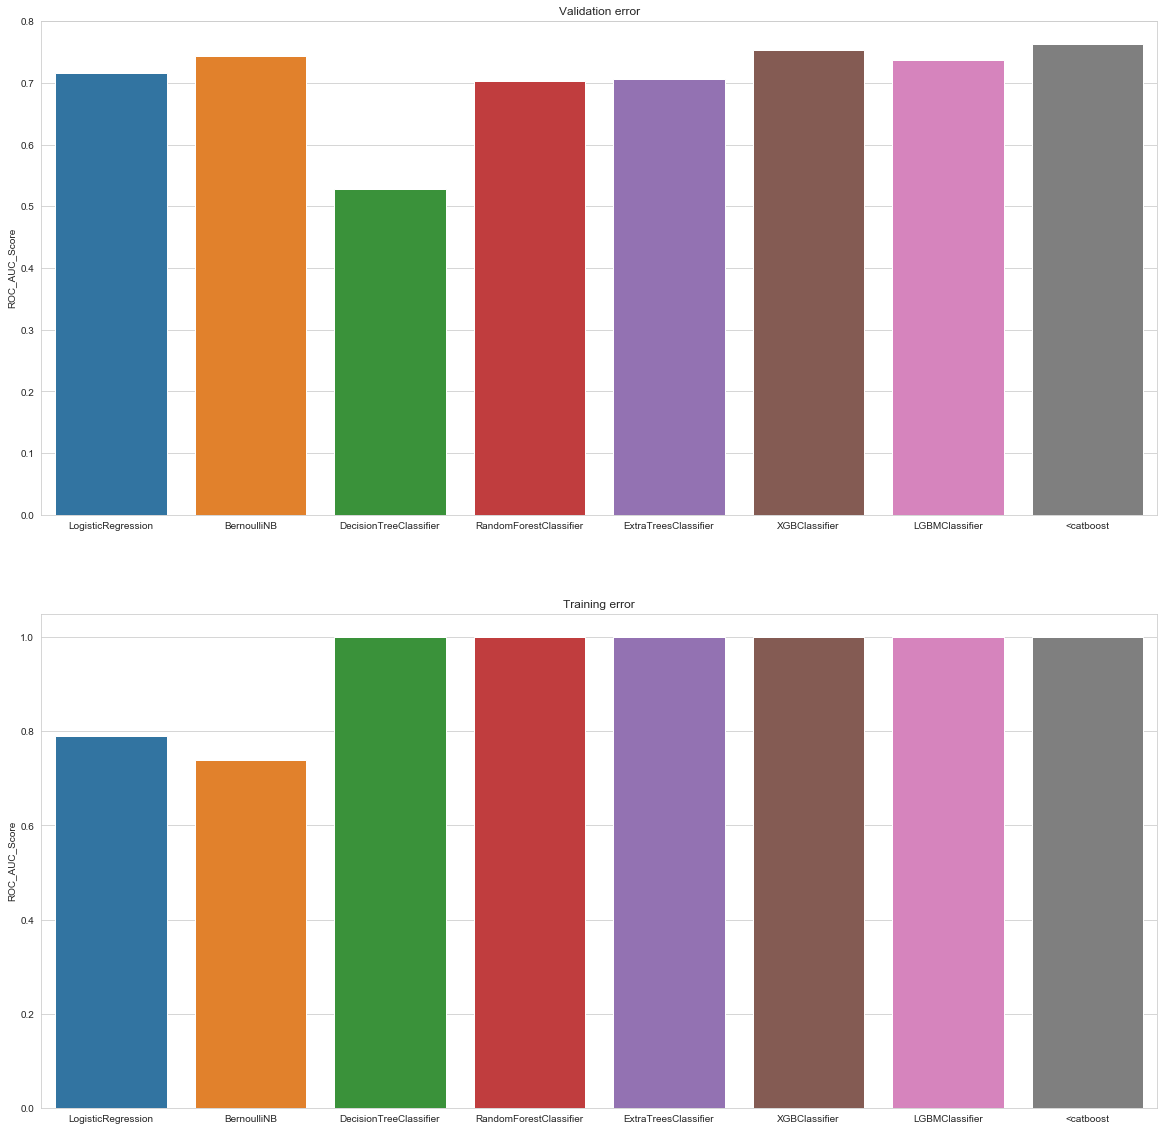

In [116]:
fig,ax = plt.subplots(2,1,figsize = (20,20))

sns.barplot(x = [str(i).split('(')[0].split('.')[0] for i in diff_models],y =a,ax=ax[0])
ax[0].set(title = 'Validation error',ylabel = 'ROC_AUC_Score')

sns.barplot(x = [str(i).split('(')[0].split('.')[0] for i in diff_models],y =b,ax=ax[1])
ax[1].set(title = 'Training error',ylabel = 'ROC_AUC_Score')

From the above graph we chose three models to go ahead:
1. ExtraTreesClassifier
2. XGBClassifier
3. CatBoostClassifier

Now we will tune the hyperparameters of these three models to increase accuracy

### 1. ExtraTreesClassifier

In [172]:
from sklearn.model_selection import RandomizedSearchCV
etc = ExtraTreesClassifier(n_jobs=-1,random_state=42,n_estimators=600,min_samples_split =8,
                          min_samples_leaf=1,max_depth=7)
etc.fit(X_train,y_train)
print(roc_auc_score(y_train,etc.predict_proba(X_train),multi_class = 'ovr'))
print(roc_auc_score(y_valid,etc.predict_proba(X_valid),multi_class ='ovr'))

0.9475274931077089
0.7925461689673575


### 2. XGBClassifier

In [193]:
xgb = XGBClassifier(n_jobs=-1,random_state=42,max_depth = 12,subsample=0.8,
                    reg_lambda = 181,n_estimators=100,min_child_weight =2)
xgb.fit(X_train,y_train)
print(roc_auc_score(y_train,xgb.predict_proba(X_train),multi_class = 'ovr'))
print(roc_auc_score(y_valid,xgb.predict_proba(X_valid),multi_class ='ovr'))

0.9659028527149202
0.7821504887741848


### 3.CatBoostClassifier

In [219]:
cbc = CatBoostClassifier(random_state=42,iterations=1000,depth=5,logging_level='Silent')
cbc.fit(X_train,y_train,eval_set=eval_set,early_stopping_rounds=30)
print(roc_auc_score(y_train,cbc.predict_proba(X_train),multi_class = 'ovr'))
print(roc_auc_score(y_valid,cbc.predict_proba(X_valid),multi_class ='ovr'))

0.9158849392662659
0.7968220817704262


## Choosing a final model

Based on the above observations ,we can say that ExtraTreesClassifier provides the best accuracy as compared to other classifiers.

With this classifier we obtained a ROC_AUC score of 0.79 on the validation data